In [1]:
import sys
from importlib import reload 
sys.path.append('./lib')

In [2]:
import utils  # expand_to_hyperboloid
utils = reload(utils)

import distances  # Distances, DistancesAggregator, ProductDistances
distances = reload(distances)
from distances import Distances, ProductDistances

import dssm  # DSSM_V2, JustEmbedding
dssm = reload(dssm)

import layers  # SphericalExponentialMapLayer, HyperbolicalExponentialMapLayer
layers = reload(layers)

In [3]:
utils.self_tests()

expand_to_hyperboloid unittest #1


In [4]:
distances.self_tests()

DistancesAggregator unittest #1...
DistancesAggregator unittest #2...
ProductDistances unittest #1...
ProductDistances unittest #2...
ProductDistances unittest #3...
ProductDistances unittest #4...
str(pd) = E2,S3,H3


In [5]:
layers.self_tests()

SphericalExponentialMapLayer UT 1
SphericalExponentialMapLayer UT 2
HyperbolicalExponentialMapLayer UT 1
HyperbolicalExponentialMapLayer UT 2


________________________

In [6]:
import networkx as nx
import numpy as np
import tensorflow as tf
import tqdm

assert int(tf.__version__.split(".")[0]) >= 2

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [7]:
def make_model(l=312):
    return dssm.JustEmbedding(l, emb_size=10)

def make_model_2(emb_size=10, l=312):
    return dssm.JustEmbedding(l, emb_size=emb_size)

def make_distances(for_ranking=True):
    return [
        ProductDistances([
            (10, Distances("euclidian_corrected", scalable=False))
        ], "sum"),
        ProductDistances([
            (10, Distances("triple_trainable_l0_corrected", scalable=True))
        ], "sum"),
        ProductDistances([
            (10, Distances("triple_trainable_l1_sq_corrected", scalable=True))
        ], "sum"),
        ProductDistances([
            (10, Distances("triple_trainable_l1_corrected", scalable=True))
        ], "sum"),
        ProductDistances([
            (10, Distances("inverted_dot", scalable=True))
        ], "sum"),
        ProductDistances([
            (10, Distances("expanded_hyp", scalable=True))
        ], "sum"),
        ProductDistances([
            (10, Distances("spherical", scalable=True))
        ], "sum"),
        ProductDistances([
            (5, Distances("expanded_hyp", scalable=True)),
            (5, Distances("expanded_hyp", scalable=True)),
        ]),
        ProductDistances([
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
        ]),
        ProductDistances([
            (5, Distances("spherical", scalable=True)),
            (5, Distances("spherical", scalable=True)),
        ]),
        ProductDistances([
            (2, Distances("spherical", scalable=True)),
            (2, Distances("spherical", scalable=True)),
            (2, Distances("spherical", scalable=True)),
            (2, Distances("spherical", scalable=True)),
            (2, Distances("spherical", scalable=True)),
        ]),
        ProductDistances([
            (5, Distances("spherical", scalable=True)),
            (5, Distances("expanded_hyp", scalable=True)),
        ]),
        ProductDistances([
            (2, Distances("spherical", scalable=True)),
            (2, Distances("spherical", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("euclidian", scalable=True)),
        ]),
    ]


def make_distances_3():
    return [
        ProductDistances([
            (11, Distances("spherical", scalable=True))
        ], "sum"),
        ProductDistances([
            (6, Distances("spherical", scalable=True)),
            (6, Distances("spherical", scalable=True)),
        ]),
        ProductDistances([
            (3, Distances("spherical", scalable=True)),
            (3, Distances("spherical", scalable=True)),
            (3, Distances("spherical", scalable=True)),
            (3, Distances("spherical", scalable=True)),
            (3, Distances("spherical", scalable=True)),
        ]),
        ProductDistances([
            (6, Distances("spherical", scalable=True)),
            (5, Distances("expanded_hyp", scalable=True)),
        ]),
        ProductDistances([
            (3, Distances("spherical", scalable=True)),
            (3, Distances("spherical", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("expanded_hyp", scalable=True)),
            (2, Distances("euclidian", scalable=True)),
        ]),
    ]


def make_distances_exp_dot(k=1):
    return [
        ProductDistances([
            (10, Distances("exp_minus_dot", scalable=True))
        ], "sum")
        for _ in range(k)
    ]


def make_distances_4():
    # only not-corrected ttl1 metrices
    return [
        ProductDistances([
            (10, Distances("triple_trainable_l1_sq", scalable=True))
        ], "sum"),
        ProductDistances([
            (10, Distances("triple_trainable_l1", scalable=True))
        ], "sum"),
    ]

_____________


### USCA312 fake product spaces example
**(no exponential map, just default gradients & adam optimizer)**

In [8]:
_, distances_matrix = utils.get_dataset("usca312")

Loading from ../datasets/usca312.edges


In [9]:
d = make_model()
qs = d.sparse_arange(312)  # queries
# r_matrix = 1 * (distances_matrix <= 1.001)  ## BUGS EVERYWHERE
distances_matrix.shape

(312, 312)

In [10]:
distances_matrix

array([[0.   , 1.167, 1.579, ..., 1.209, 0.866, 1.112],
       [1.167, 0.   , 0.413, ..., 0.045, 1.904, 0.082],
       [1.579, 0.413, 0.   , ..., 0.37 , 2.312, 0.467],
       ...,
       [1.209, 0.045, 0.37 , ..., 0.   , 1.95 , 0.107],
       [0.866, 1.904, 2.312, ..., 1.95 , 0.   , 1.87 ],
       [1.112, 0.082, 0.467, ..., 0.107, 1.87 , 0.   ]])

In [11]:
dm_copy = np.copy(distances_matrix)
r_matrix = np.copy(distances_matrix)

for i in range(dm_copy.shape[0]):
    dm_copy[i].sort()
    r_matrix[i] = distances_matrix[i] <= dm_copy[i, 1] + 1e-3
r_matrix -= np.eye(r_matrix.shape[0])

In [12]:
distances_matrix

array([[0.   , 1.167, 1.579, ..., 1.209, 0.866, 1.112],
       [1.167, 0.   , 0.413, ..., 0.045, 1.904, 0.082],
       [1.579, 0.413, 0.   , ..., 0.37 , 2.312, 0.467],
       ...,
       [1.209, 0.045, 0.37 , ..., 0.   , 1.95 , 0.107],
       [0.866, 1.904, 2.312, ..., 1.95 , 0.   , 1.87 ],
       [1.112, 0.082, 0.467, ..., 0.107, 1.87 , 0.   ]])

In [13]:
r_matrix.sum(-1)  # edges per vertex

array([1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2.,
       1., 1., 1., 1., 1.

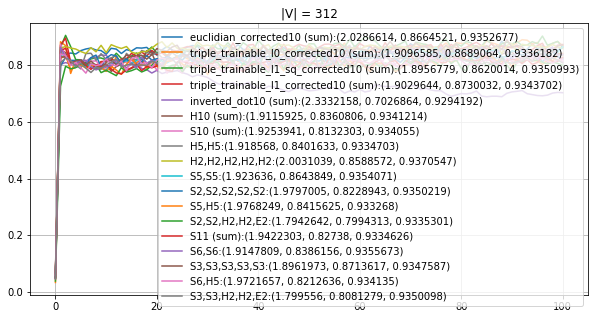

0.8664521	euclidian_corrected10 (sum)
0.8689064	triple_trainable_l0_corrected10 (sum)
0.8620014	triple_trainable_l1_sq_corrected10 (sum)
0.8730032	triple_trainable_l1_corrected10 (sum)
0.7026864	inverted_dot10 (sum)
0.8360806	H10 (sum)
0.8132303	S10 (sum)
0.8401633	H5,H5
0.8588572	H2,H2,H2,H2,H2
0.8643849	S5,S5
0.8228943	S2,S2,S2,S2,S2
0.8415625	S5,H5
0.7994313	S2,S2,H2,H2,E2
0.82738	S11 (sum)
0.8386156	S6,S6
0.8713617	S3,S3,S3,S3,S3
0.8212636	S6,H5
0.8081279	S3,S3,H2,H2,E2


In [15]:
total_loss_story = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances()+make_distances_3(), iters=2000, learning_rate=0.01,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True,
    loss_name="1/dist"
)

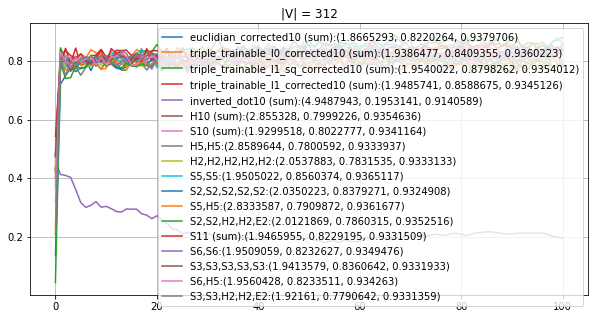

0.8220264	euclidian_corrected10 (sum)
0.8409355	triple_trainable_l0_corrected10 (sum)
0.8798262	triple_trainable_l1_sq_corrected10 (sum)
0.8588675	triple_trainable_l1_corrected10 (sum)
0.1953141	inverted_dot10 (sum)
0.7999226	H10 (sum)
0.8022777	S10 (sum)
0.7800592	H5,H5
0.7831535	H2,H2,H2,H2,H2
0.8560374	S5,S5
0.8379271	S2,S2,S2,S2,S2
0.7909872	S5,H5
0.7860315	S2,S2,H2,H2,E2
0.8229195	S11 (sum)
0.8232627	S6,S6
0.8360642	S3,S3,S3,S3,S3
0.8233511	S6,H5
0.7790642	S3,S3,H2,H2,E2


In [16]:
total_loss_story2 = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances()+make_distances_3(), iters=2000, learning_rate=0.1,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True,
    loss_name="1/dist"
)

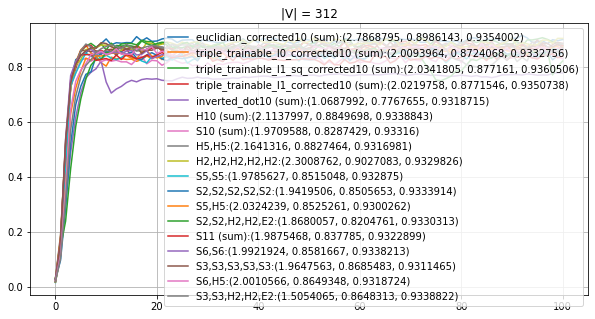

0.8986143	euclidian_corrected10 (sum)
0.8724068	triple_trainable_l0_corrected10 (sum)
0.877161	triple_trainable_l1_sq_corrected10 (sum)
0.8771546	triple_trainable_l1_corrected10 (sum)
0.7767655	inverted_dot10 (sum)
0.8849698	H10 (sum)
0.8287429	S10 (sum)
0.8827464	H5,H5
0.9027083	H2,H2,H2,H2,H2
0.8515048	S5,S5
0.8505653	S2,S2,S2,S2,S2
0.8525261	S5,H5
0.8204761	S2,S2,H2,H2,E2
0.837785	S11 (sum)
0.8581667	S6,S6
0.8685483	S3,S3,S3,S3,S3
0.8649348	S6,H5
0.8648313	S3,S3,H2,H2,E2


In [17]:
total_loss_story3 = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances()+make_distances_3(), iters=2000, learning_rate=0.001,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True,
    loss_name="1/dist"
)

P ~ 1/d

In [18]:
for d, l0, l1, l2 in zip(make_distances()+make_distances_3(), total_loss_story, total_loss_story2, total_loss_story3):
    ar = np.array([x[-1] for x in [l0, l1, l2]])
    # print(f"{ar[:, 0].argmin(), ar[:, 1:].argmax(axis=0)}\t{d}")
    print(f"{ar[:, 0].min(), *ar[:, 1:].max(axis=0)}\t{d}")

(1.8665293, 0.8986143, 0.9379706)	euclidian_corrected10 (sum)
(1.9096585, 0.8724068, 0.9360223)	triple_trainable_l0_corrected10 (sum)
(1.8956779, 0.8798262, 0.9360506)	triple_trainable_l1_sq_corrected10 (sum)
(1.9029644, 0.8771546, 0.9350738)	triple_trainable_l1_corrected10 (sum)
(1.0687992, 0.7767655, 0.9318715)	inverted_dot10 (sum)
(1.9115925, 0.8849698, 0.9354636)	H10 (sum)
(1.9253941, 0.8287429, 0.9341164)	S10 (sum)
(1.918568, 0.8827464, 0.9334703)	H5,H5
(2.0031039, 0.9027083, 0.9370547)	H2,H2,H2,H2,H2
(1.923636, 0.8643849, 0.9365117)	S5,S5
(1.9419506, 0.8505653, 0.9350219)	S2,S2,S2,S2,S2
(1.9768249, 0.8525261, 0.9361677)	S5,H5
(1.7942642, 0.8204761, 0.9352516)	S2,S2,H2,H2,E2
(1.9422303, 0.837785, 0.9334626)	S11 (sum)
(1.9147809, 0.8581667, 0.9355673)	S6,S6
(1.8961973, 0.8713617, 0.9347587)	S3,S3,S3,S3,S3
(1.9560428, 0.8649348, 0.934263)	S6,H5
(1.5054065, 0.8648313, 0.9350098)	S3,S3,H2,H2,E2


P ~ exp(1/d) (old)

In [20]:
for d, l0, l1, l2 in zip(make_distances()+make_distances_3(), total_loss_story, total_loss_story2, total_loss_story3):
    ar = np.array([x[-1] for x in [l0, l1, l2]])
    # print(f"{ar[:, 0].argmin(), ar[:, 1:].argmax(axis=0)}\t{d}")
    print(f"{ar[:, 0].min(), *ar[:, 1:].max(axis=0)}\t{d}")

(0.9326434, 0.9107906, 0.9353654)	euclidian_corrected10 (sum)
(1.129513, 0.9326211, 0.9350468)	triple_trainable_l0_corrected10 (sum)
(1.0528692, 0.9387414, 0.9392185)	triple_trainable_l1_sq_corrected10 (sum)
(1.0641228, 0.946921, 0.9377475)	triple_trainable_l1_corrected10 (sum)
(0.575974, 1.0, 0.9332441)	inverted_dot10 (sum)
(1.2169582, 0.8070246, 0.9367493)	H10 (sum)
(3.6201458, 0.8011958, 0.9313335)	S10 (sum)
(0.9309645, 0.8899573, 0.936013)	H5,H5
(0.9105442, 0.8961004, 0.9383972)	H2,H2,H2,H2,H2
(2.3850929, 0.8205037, 0.9315501)	S5,S5
(1.9036134, 0.8498968, 0.931254)	S2,S2,S2,S2,S2
(2.0866186, 0.8350079, 0.9308122)	S5,H5
(1.8167501, 0.8871005, 0.9308316)	S2,S2,H2,H2,E2
(4.1501954, 0.7973474, 0.9298412)	S11 (sum)
(2.170111, 0.8018859, 0.9313458)	S6,S6
(1.8895017, 0.8557527, 0.9326814)	S3,S3,S3,S3,S3
(1.9926183, 0.8381035, 0.9304727)	S6,H5
(1.8405941, 0.8716018, 0.9300892)	S3,S3,H2,H2,E2


__________________

# CS PhDs

In [19]:
G, distances_matrix,r_matrix = utils.get_dataset(distances_matrix=True, edges_matrix=True)

Loading from ../datasets/CSPhDs.edges
|V| = 1025, |E| = 1043


In [20]:
make_model_g = lambda : make_model(len(G.nodes()))
d = make_model_g()
qs = d.sparse_arange(len(G.nodes()))

In [21]:
r_matrix

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [22]:
distances_matrix

array([[ 0,  1,  2, ..., 17, 17, 17],
       [ 1,  0,  1, ..., 16, 16, 16],
       [ 2,  1,  0, ..., 16, 16, 16],
       ...,
       [17, 16, 16, ...,  0,  2,  2],
       [17, 16, 16, ...,  2,  0,  2],
       [17, 16, 16, ...,  2,  2,  0]])

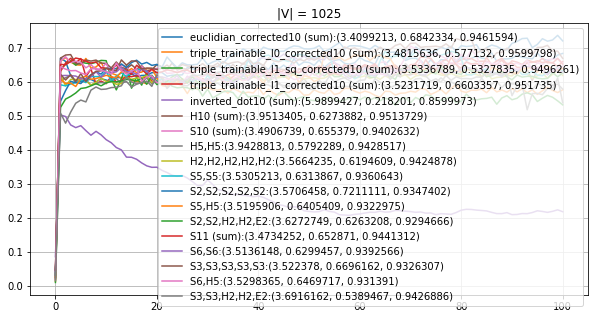

0.6842334	euclidian_corrected10 (sum)
0.577132	triple_trainable_l0_corrected10 (sum)
0.5327835	triple_trainable_l1_sq_corrected10 (sum)
0.6603357	triple_trainable_l1_corrected10 (sum)
0.218201	inverted_dot10 (sum)
0.6273882	H10 (sum)
0.655379	S10 (sum)
0.5792289	H5,H5
0.6194609	H2,H2,H2,H2,H2
0.6313867	S5,S5
0.7211111	S2,S2,S2,S2,S2
0.6405409	S5,H5
0.6263208	S2,S2,H2,H2,E2
0.652871	S11 (sum)
0.6299457	S6,S6
0.6696162	S3,S3,S3,S3,S3
0.6469717	S6,H5
0.5389467	S3,S3,H2,H2,E2


In [23]:
total_loss_story = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances()+make_distances_3(), iters=2000, learning_rate=0.1,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True,
    loss_name="1/dist"
)

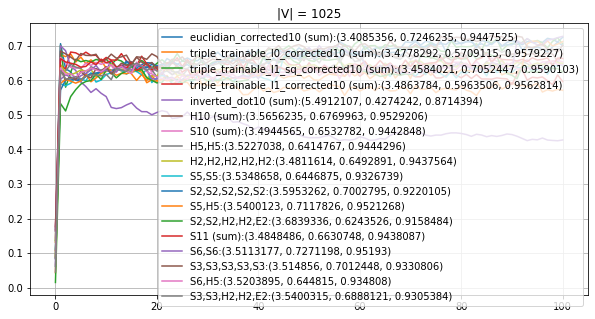

0.7246235	euclidian_corrected10 (sum)
0.5709115	triple_trainable_l0_corrected10 (sum)
0.7052447	triple_trainable_l1_sq_corrected10 (sum)
0.5963506	triple_trainable_l1_corrected10 (sum)
0.4274242	inverted_dot10 (sum)
0.6769963	H10 (sum)
0.6532782	S10 (sum)
0.6414767	H5,H5
0.6492891	H2,H2,H2,H2,H2
0.6446875	S5,S5
0.7002795	S2,S2,S2,S2,S2
0.7117826	S5,H5
0.6243526	S2,S2,H2,H2,E2
0.6630748	S11 (sum)
0.7271198	S6,S6
0.7012448	S3,S3,S3,S3,S3
0.644815	S6,H5
0.6888121	S3,S3,H2,H2,E2


In [24]:
total_loss_story2 = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances()+make_distances_3(), iters=2000, learning_rate=0.05,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True,
    loss_name="1/dist"
)

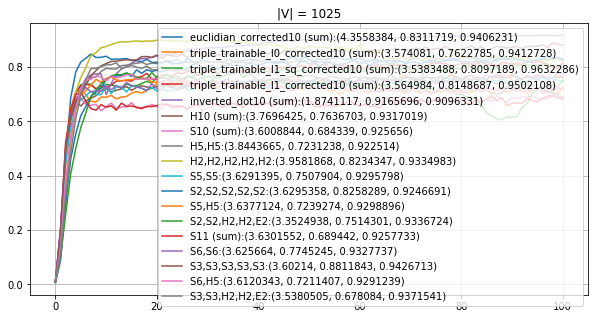

0.8311719	euclidian_corrected10 (sum)
0.7622785	triple_trainable_l0_corrected10 (sum)
0.8097189	triple_trainable_l1_sq_corrected10 (sum)
0.8148687	triple_trainable_l1_corrected10 (sum)
0.9165696	inverted_dot10 (sum)
0.7636703	H10 (sum)
0.684339	S10 (sum)
0.7231238	H5,H5
0.8234347	H2,H2,H2,H2,H2
0.7507904	S5,S5
0.8258289	S2,S2,S2,S2,S2
0.7239274	S5,H5
0.7514301	S2,S2,H2,H2,E2
0.689442	S11 (sum)
0.7745245	S6,S6
0.8811843	S3,S3,S3,S3,S3
0.7211407	S6,H5
0.678084	S3,S3,H2,H2,E2


In [25]:
total_loss_story3 = utils.estimate_signatures_softmax(
    make_model_2, qs, distances_matrix=distances_matrix, r_matrix=r_matrix,
    dists=make_distances()+make_distances_3(), iters=2000, learning_rate=0.001,
    loss_eval_interval=20, draw_interval=20,
    print_results=True, different_d_sum=True,
    loss_name="1/dist"
)

P ~ 1/d

In [26]:
for d, l0, l1, l2 in zip(make_distances()+make_distances_3(), total_loss_story, total_loss_story2, total_loss_story3):
    ar = np.array([x[-1] for x in [l0, l1, l2]])
    # print(f"{ar[:, 0].argmin(), ar[:, 1:].argmax(axis=0)}\t{d}")
    print(f"{ar[:, 0].min(), *ar[:, 1:].max(axis=0)}\t{d}")

(3.4085356, 0.8311719, 0.9461594)	euclidian_corrected10 (sum)
(3.4778292, 0.7622785, 0.9599798)	triple_trainable_l0_corrected10 (sum)
(3.4584021, 0.8097189, 0.9632286)	triple_trainable_l1_sq_corrected10 (sum)
(3.4863784, 0.8148687, 0.9562814)	triple_trainable_l1_corrected10 (sum)
(1.8741117, 0.9165696, 0.9096331)	inverted_dot10 (sum)
(3.5656235, 0.7636703, 0.9529206)	H10 (sum)
(3.4906739, 0.684339, 0.9442848)	S10 (sum)
(3.5227038, 0.7231238, 0.9444296)	H5,H5
(3.4811614, 0.8234347, 0.9437564)	H2,H2,H2,H2,H2
(3.5305213, 0.7507904, 0.9360643)	S5,S5
(3.5706458, 0.8258289, 0.9347402)	S2,S2,S2,S2,S2
(3.5195906, 0.7239274, 0.9521268)	S5,H5
(3.3524938, 0.7514301, 0.9336724)	S2,S2,H2,H2,E2
(3.4734252, 0.689442, 0.9441312)	S11 (sum)
(3.5113177, 0.7745245, 0.95193)	S6,S6
(3.514856, 0.8811843, 0.9426713)	S3,S3,S3,S3,S3
(3.5203895, 0.7211407, 0.934808)	S6,H5
(3.5380505, 0.6888121, 0.9426886)	S3,S3,H2,H2,E2


P ~ exp(1/d) (old)

In [35]:
for d, l0, l1, l2 in zip(make_distances()+make_distances_3(), total_loss_story, total_loss_story2, total_loss_story3):
    ar = np.array([x[-1] for x in [l0, l1, l2]])
    # print(f"{ar[:, 0].argmin(), ar[:, 1:].argmax(axis=0)}\t{d}")
    print(f"{ar[:, 0].min(), *ar[:, 1:].max(axis=0)}\t{d}")

(1.8098172, 0.9559585, 0.9808082)	euclidian_corrected10 (sum)
(2.2279522, 0.960945, 0.9802961)	triple_trainable_l0_corrected10 (sum)
(1.9607508, 0.9785895, 0.9903134)	triple_trainable_l1_sq_corrected10 (sum)
(2.0552929, 0.962791, 0.9856802)	triple_trainable_l1_corrected10 (sum)
(1.9967745, 0.9994797, 0.973646)	inverted_dot10 (sum)
(1.8107239, 0.748669, 0.9457685)	H10 (sum)
(4.9480945, 0.5829606, 0.9170498)	S10 (sum)
(1.5592662, 0.9762602, 0.9495725)	H5,H5
(1.5402242, 0.997561, 0.9707478)	H2,H2,H2,H2,H2
(4.3183433, 0.7330884, 0.9226816)	S5,S5
(3.4005886, 0.8629019, 0.9218349)	S2,S2,S2,S2,S2
(5.9599435, 0.7812334, 0.914062)	S5,H5
(3.5363456, 0.8908502, 0.9278877)	S2,S2,H2,H2,E2
(4.9724396, 0.5724812, 0.9169813)	S11 (sum)
(4.2928667, 0.7482585, 0.9254386)	S6,S6
(3.4138233, 0.8760613, 0.9251015)	S3,S3,S3,S3,S3
(6.0170009, 0.8041359, 0.9179397)	S6,H5
(3.7587853, 0.883576, 0.9295765)	S3,S3,H2,H2,E2
